In [1]:
import sqlite3

# Connect to SQLite database (this will create the database if it doesn't exist)
conn = sqlite3.connect('flights.db')

# Create a cursor object using the cursor() method
cursor = conn.cursor()

# Create table for real flights
cursor.execute('''
CREATE TABLE IF NOT EXISTS real_flights (
    Base TEXT,
    Lof_ID TEXT,
    DAY_OF_ORIGIN TEXT,
    Flights TEXT,
    Hops TEXT
)
''')

# Create table for planned flights
cursor.execute('''
CREATE TABLE IF NOT EXISTS planned_flights (
    dateoforigin TEXT,
    airportbase TEXT,
    flights TEXT,
    hops TEXT
)
''')

# Commit the transaction
conn.commit()

# Close the connection
conn.close()


In [5]:
import pandas as pd

# Assuming you have the Excel file path
excel_path = 'real vs planned lofs_1_year.xlsx'

# Load the Excel file without specifying a sheet name
xls = pd.ExcelFile(excel_path)

# Print all sheet names
print(xls.sheet_names)


['real netline lof', 'planned rim lof ']


In [7]:
# @title
import pandas as pd

# Replace with your actual file path
file_path = 'real vs planned lofs_1_year.xlsx'

# Load sheets
real_lofs_df = pd.read_excel(file_path, sheet_name='real netline lof')
planned_lofs_df = pd.read_excel(file_path, sheet_name='planned rim lof ')

# Display the first few rows of each DataFrame
print("Real LOFs DataFrame:")
print(real_lofs_df.head())
print("\nPlanned LOFs DataFrame:")
print(planned_lofs_df.head())


Real LOFs DataFrame:
  Base               Lof_ID DAY_OF_ORIGIN                            Flights  \
0  AAR   2023.11.08_95AL73Q    2023-11-08                             FR9401   
1  ACE  2023.03.28_324FR738    2023-03-28  FR2305 / FR2306 / FR2001 / FR2002   
2  ACE  2023.03.28_349FR738    2023-03-28  FR5911 / FR5910 / FR3488 / FR3489   
3  ACE  2023.03.29_324FR738    2023-03-29  FR2001 / FR2002 / FR4359 / FR4358   
4  ACE  2023.03.29_349FR738    2023-03-29    FR251 / FR250 / FR2018 / FR2017   

                                Hops  
0                             AARFAO  
1  ACENOC / NOCACE / ACESCQ / SCQACE  
2  ACEDUB / DUBACE / ACEVLC / VLCACE  
3  ACESCQ / SCQACE / ACEBVA / BVAACE  
4  ACESTN / STNACE / ACEMAD / MADACE  

Planned LOFs DataFrame:
  dateoforigin airportbase                                            flights  \
0   2023-04-29         ACE                  FR8285 / FR8284 / FR3488 / FR3489   
1   2023-04-29         AGA                  FR9499 / FR9500 / FR1245 / FR1244

In [34]:
# Display the first few rows of each DataFrame
print("Real LOFs DataFrame:")
print(real_lofs_df.head())
print(real_lofs_df.columns)
print("\nPlanned LOFs DataFrame:")
print(planned_lofs_df.head())
print(planned_lofs_df.columns)

Real LOFs DataFrame:
  Base               Lof_ID DAY_OF_ORIGIN                            Flights  \
0  AAR   2023.11.08_95AL73Q    2023-11-08                             FR9401   
1  ACE  2023.03.28_324FR738    2023-03-28  FR2305 / FR2306 / FR2001 / FR2002   
2  ACE  2023.03.28_349FR738    2023-03-28  FR5911 / FR5910 / FR3488 / FR3489   
3  ACE  2023.03.29_324FR738    2023-03-29  FR2001 / FR2002 / FR4359 / FR4358   
4  ACE  2023.03.29_349FR738    2023-03-29    FR251 / FR250 / FR2018 / FR2017   

                                Hops  
0                             AARFAO  
1  ACENOC / NOCACE / ACESCQ / SCQACE  
2  ACEDUB / DUBACE / ACEVLC / VLCACE  
3  ACESCQ / SCQACE / ACEBVA / BVAACE  
4  ACESTN / STNACE / ACEMAD / MADACE  
Index(['Base', 'Lof_ID', 'DAY_OF_ORIGIN', 'Flights', 'Hops'], dtype='object')

Planned LOFs DataFrame:
  dateoforigin airportbase                                            flights  \
0   2023-04-29         ACE                  FR8285 / FR8284 / FR3488 / FR3489   

In [8]:
# @title
import pandas as pd

# Assuming real_lofs_df and planned_lofs_df are already loaded and have the necessary columns

# Ensure date formats are consistent and aligned
real_lofs_df['DAY_OF_ORIGIN'] = pd.to_datetime(real_lofs_df['DAY_OF_ORIGIN']).dt.strftime('%Y-%m-%d')
planned_lofs_df['dateoforigin'] = pd.to_datetime(planned_lofs_df['dateoforigin']).dt.strftime('%Y-%m-%d')

# Normalize the Real LOFs DataFrame
real_flights_expanded = real_lofs_df.set_index(['Lof_ID', 'DAY_OF_ORIGIN', 'Base'])['Flights'].str.split(' / ', expand=True).stack().reset_index(name='Flight').drop('level_3', axis=1)
real_flights_expanded.rename(columns={'DAY_OF_ORIGIN': 'dateoforigin'}, inplace=True) # Aligning the date column names

# Normalize the Planned LOFs DataFrame
planned_flights_expanded = planned_lofs_df.set_index(['dateoforigin', 'airportbase'])['flights'].str.split(' / ', expand=True).stack().reset_index(name='Flight').drop('level_2', axis=1)

# Identify cancellations by finding flights in planned_flights_expanded not in real_flights_expanded
cancellations = pd.merge(planned_flights_expanded, real_flights_expanded, on=['Flight', 'dateoforigin'], how='left', indicator=True).query('_merge == "left_only"')

# Clean up the cancellations DataFrame to include necessary information
cancellations_cleaned = cancellations[['dateoforigin', 'airportbase', 'Flight']].drop_duplicates()

# Export to Excel
cancellations_cleaned.to_excel('cancelled_flights2.xlsx', index=False)

print("Cancelled flights have been identified and exported to 'cancelled_flights.xlsx'.")


Cancelled flights have been identified and exported to 'cancelled_flights.xlsx'.


In [9]:
import pandas as pd

# Assuming the cancelled flights data is in 'cancelled_flights.xlsx'
# Load the data
cancelled_flights_df = pd.read_excel('cancelled_flights2.xlsx')

# Display the first few rows to verify the content
print(cancelled_flights_df.head())

# Descriptive statistics for the cancellation dates
date_stats = cancelled_flights_df['dateoforigin'].describe()

# Count of cancellations by airport base
airportbase_cancellations = cancelled_flights_df['airportbase'].value_counts()

# Count of cancellations by date
date_cancellations = cancelled_flights_df['dateoforigin'].value_counts()

# Display the results
print(date_stats)
print(airportbase_cancellations)
print(date_cancellations)


  dateoforigin airportbase  Flight
0   2023-04-29         EDI   RK597
1   2023-04-29         EDI   RK596
2   2023-04-29         EDI  RK1133
3   2023-04-29         EDI  RK1132
4   2023-04-29         EDI  RK6654
count         126360
unique           421
top       2022-11-04
freq            2099
Name: dateoforigin, dtype: object
STN    17410
MAN     9817
KTW     5748
BGY     5537
EDI     5019
       ...  
CHQ       14
ACE        9
MAH        2
TFS        2
DUS        1
Name: airportbase, Length: 97, dtype: int64
2022-11-04    2099
2022-11-11    2081
2022-11-18    2059
2022-11-06    2034
2022-11-14    2016
              ... 
2023-03-02      32
2023-02-23      32
2023-02-09      31
2023-02-02      30
2022-12-24      27
Name: dateoforigin, Length: 421, dtype: int64


In [35]:
# Display the first few rows of each DataFrame
print("Cancelled flights DataFrame:")
print(cancelled_flights_df.head())
print(cancelled_flights_df.columns)


Cancelled flights DataFrame:
  dateoforigin airportbase  Flight
0   2023-04-29         EDI   RK597
1   2023-04-29         EDI   RK596
2   2023-04-29         EDI  RK1133
3   2023-04-29         EDI  RK1132
4   2023-04-29         EDI  RK6654
Index(['dateoforigin', 'airportbase', 'Flight'], dtype='object')


Dates of Cancellation: The 'dateoforigin' field, which seems to represent the dates of flight cancellations, spans 421 unique dates. The day with the highest number of cancellations is 2022-11-04, with 2099 cancellations.

Airport Base Cancellations: The 'airportbase' field indicates the base airport of the flights. The airport with the highest number of cancellations is STN (presumably Stansted Airport), with a total of 17410 cancellations. There are 97 unique airports listed.

Flight Identifiers: The 'Flight' column contains flight identifiers, which could be useful for finding patterns if the same flight numbers are frequently cancelled.

## **Temporal Patterns: Number of cancellations per month.**



In [10]:
import pandas as pd

# Convert 'dateoforigin' to datetime
cancelled_flights_df['dateoforigin'] = pd.to_datetime(cancelled_flights_df['dateoforigin'])

# Extract year and month from 'dateoforigin'
cancelled_flights_df['year_month'] = cancelled_flights_df['dateoforigin'].dt.to_period('M')

# Count of cancellations by month
monthly_cancellations = cancelled_flights_df['year_month'].value_counts().sort_index()

# Display the results
print(monthly_cancellations)


2022-10    39984
2022-11    46113
2022-12     2197
2023-01     1917
2023-02     1305
2023-03     2378
2023-04     3390
2023-05     4019
2023-06     4944
2023-07     4909
2023-08     4667
2023-09     4196
2023-10     3479
2023-11     2862
Freq: M, Name: year_month, dtype: int64


## **Specific days of the week with higher cancellations.**

In [11]:
# Extract day of the week from 'dateoforigin'
cancelled_flights_df['day_of_week'] = cancelled_flights_df['dateoforigin'].dt.day_name()

# Count of cancellations by day of the week
weekday_cancellations = cancelled_flights_df['day_of_week'].value_counts()

# Display the results
print(weekday_cancellations)


Monday       20236
Sunday       19309
Friday       19300
Saturday     18761
Tuesday      16650
Wednesday    16499
Thursday     15605
Name: day_of_week, dtype: int64


In [15]:
import pandas as pd

# Assuming cancelled_flights_df is your DataFrame with the cancellation data
# Convert 'dateoforigin' to datetime format if not already done
cancelled_flights_df['dateoforigin'] = pd.to_datetime(cancelled_flights_df['dateoforigin'])

# Identify the top N dates with the highest number of cancellations
N = 5  # You can adjust N based on how many top dates you want to examine
top_dates = cancelled_flights_df['dateoforigin'].value_counts().head(N).index

# For each of these top N dates, filter the dataset for detailed analysis
for date in top_dates:
    print(f"Details for {date.date()}:")
    filtered_df = cancelled_flights_df[cancelled_flights_df['dateoforigin'] == date]
    # Display the airport base and flights for this date
    print(filtered_df[['airportbase', 'Flight']])
    print("\n")

# Optionally, you can also export each filtered dataset to an Excel file for external analysis
    # filtered_df.to_excel(f'cancelled_flights_{date.date()}.xlsx', index=False)


Details for 2022-11-04:
      airportbase  Flight
48019         AGA  FR9279
48020         AGA   FR184
48021         AGA   FR185
48022         AGA  FR9298
48023         AGA  FR3429
...           ...     ...
61879         ZAG  FR2750
61880         ZAG  FR2189
61881         ZAG  FR2190
61882         ZAG  FR5866
61883         ZAG  FR5867

[2099 rows x 2 columns]


Details for 2022-11-11:
      airportbase  Flight
71189         AGP  FR8146
71190         AGP  FR8147
71191         AGP  FR2598
71192         AGP  FR7048
71193         ALC  FR2954
...           ...     ...
83957         ZAG  FR2126
83958         ZAG  FR2127
83959         ZAG  FR2130
83960         ZAG  FR5870
83961         ZAG  FR5871

[2081 rows x 2 columns]


Details for 2022-11-18:
       airportbase  Flight
115946         ALC  FR2954
115947         ALC  FR2953
115948         ALC  FR3346
115949         ALC  FR3347
115950         ALC  FR8538
...            ...     ...
126355         ZAG  FR2172
126356         ZAG  FR2123
126357 

In [16]:
import pandas as pd

# Assuming 'cancelled_flights_df' is your DataFrame containing cancellation data
cancelled_flights_df['dateoforigin'] = pd.to_datetime(cancelled_flights_df['dateoforigin']).dt.date

# Group cancellations by date, list unique flights and bases for each date
cancelled_flights_grouped = cancelled_flights_df.groupby('dateoforigin').agg({
    'Flight': lambda x: list(set(x)),
    'airportbase': lambda x: list(set(x))
})

# Calculate the number of cancellations for each day
cancelled_flights_grouped['cancellations_count'] = cancelled_flights_df.groupby('dateoforigin')['Flight'].count()

# Filter for days with high cancellations, based on a threshold (mean + std deviation for example)
mean_cancellations = cancelled_flights_grouped['cancellations_count'].mean()
std_cancellations = cancelled_flights_grouped['cancellations_count'].std()
high_cancellation_days = cancelled_flights_grouped[cancelled_flights_grouped['cancellations_count'] > mean_cancellations + std_cancellations]

# Display results
print(high_cancellation_days[['Flight', 'airportbase', 'cancellations_count']])


                                                         Flight  \
dateoforigin                                                      
2022-10-01    [FR5524, FR4177, FR627, FR6882, FR2701, FR558,...   
2022-10-02    [FR3553, FR8968, FR7728, FR1451, FR1501, FR663...   
2022-10-03    [FR8660, FR9390, FR5317, FR8968, FR6882, FR761...   
2022-10-04    [FR4177, FR1838, FR8968, FR627, FR6882, FR3190...   
2022-10-05    [FR5317, FR3438, RK1103, FR9065, FR1501, FR267...   
2022-10-06    [FR4177, FR8968, FR8609, FR8368, FR6882, FR722...   
2022-10-07    [FR8660, FR8968, FR3438, FR6882, FR1949, FR271...   
2022-10-08    [FR4177, FR627, FR3190, FR2701, FR558, FR7222,...   
2022-10-09    [FR3141, FR3553, FR1838, FR8968, FR1280, FR979...   
2022-10-10    [FR3141, FR9390, FR8660, FR5317, FR8968, FR740...   
2022-10-11    [FR7222, FR2910, FR1501, FR5120, FR1633, FR688...   
2022-10-12    [FR5317, FR3438, FR7618, RK1103, FR385, FR2910...   
2022-10-13    [FR7222, FR2910, FR1501, FR6886, FR5177, FR262..

**November 4, 2022**: Recorded 2099 cancellations, impacting bases such as SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, among others.

**October 30, 2022**: Saw 1817 cancellations, with flights from SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, and additional bases being canceled.

**October 31, 2022:** Experienced 1786 cancellations, affecting a wide range of bases including SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, etc.

**November 6, 2022:** Had 2034 cancellations, with flights from bases like SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, among others, being canceled.

**November 7, 2022:** With 1997 cancellations, airports including SKG, LTN, DUB, WRO, BUD, VLC, AGA, LPL, POZ were notably affected.

**November 11, 2022:** Notched up 2081 cancellations, impacting bases such as SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, among others.

**November 5, 2022:** Saw 1867 cancellations, with significant impacts on SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, and more.

**November 14, 2022:** Recorded 2016 cancellations, affecting a wide array of bases including SKG, LTN, DUB, WRO, BUD, VLC, AGA, LPL, POZ, etc.

**November 18, 2022**: Experienced 2059 cancellations, with notable impacts on bases such as SKG, LTN, DUB, WRO, BUD, VLC, AGA, LPL, POZ, among others.

**November 19, 2022:** Had 1857 cancellations, impacting SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, and others.

**November 20, 2022:** Saw 1952 cancellations, with significant impacts on bases like SKG, LTN, DUB, WRO, BUD, VLC, AGA, LPL, POZ, among others.

**November 12, 2022:** Recorded 1901 cancellations, affecting SKG, LTN, DUB, WRO, BUD, VLC, AGA, LPL, POZ, and additional bases.

**November 13, 2022:** Experienced 1935 cancellations, with a wide range of bases including SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ, being affected.

**November 21, 2022**: With 1917 cancellations, airports such as SKG, LTN, DUB, WRO, BUD, AGA, VLC, LPL, POZ were notably impacted.

**October 26, 2022:** Saw 1631 cancellations, impacting SKG, LTN, DUB, WRO, BUD, VLC, AGA, LPL, POZ, among others.


## **Possible Reasons**

1. Possibly due to the industry's struggle to meet rising travel demand post-pandemic downsizing, as well as operational challenges. Or "On November 4, 2022, Spain closed parts of its airspace due to the threat posed by falling debris from a Chinese rocket. This caused delays for 300 flights across Spanish airports, affecting numerous regions including Catalonia. The debris came from the Long March 5B rocket, which was re-entering the Earth's atmosphere"

2. October 30, 2022, Schiphol Airport in Amsterdam faced significant operational challenges due to a security staff shortage, leading to extended passenger caps and reduced capacity. This situation resulted in long lines and numerous flight cancellations, as the airport struggled to manage the influx of travelers with the available staff​



I will remove all 2022 and look 2023 onward

In [17]:
import pandas as pd


# Convert 'dateoforigin' to datetime format
cancelled_flights_df['dateoforigin'] = pd.to_datetime(cancelled_flights_df['dateoforigin'])

# Filter the DataFrame to include only data from 2023 onwards
cancelled_flights_2023_df = cancelled_flights_df[cancelled_flights_df['dateoforigin'].dt.year >= 2023]

# Extract year and month for grouping and analyze monthly cancellations
cancelled_flights_2023_df['year_month'] = cancelled_flights_2023_df['dateoforigin'].dt.to_period('M')
monthly_cancellations_2023 = cancelled_flights_2023_df['year_month'].value_counts().sort_index()

# Analyze cancellations by day of the week
cancelled_flights_2023_df['day_of_week'] = cancelled_flights_2023_df['dateoforigin'].dt.day_name()
day_of_week_cancellations_2023 = cancelled_flights_2023_df['day_of_week'].value_counts()

# Identify top airports for cancellations in 2023 onwards
top_airports_cancellations_2023 = cancelled_flights_2023_df['airportbase'].value_counts().head(10)

print(monthly_cancellations_2023)
print(day_of_week_cancellations_2023)
print(top_airports_cancellations_2023)


2023-01    1917
2023-02    1305
2023-03    2378
2023-04    3390
2023-05    4019
2023-06    4944
2023-07    4909
2023-08    4667
2023-09    4196
2023-10    3479
2023-11    2862
Freq: M, Name: year_month, dtype: int64
Monday       5951
Friday       5901
Saturday     5845
Sunday       5374
Tuesday      5173
Wednesday    4968
Thursday     4854
Name: day_of_week, dtype: int64
STN    8632
MAN    6976
KTW    4899
EDI    3574
BFS    3369
WRO     843
WMI     815
CRL     762
POZ     750
MRS     414
Name: airportbase, dtype: int64


<ipython-input-17-503b5b5ffc8c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_flights_2023_df['year_month'] = cancelled_flights_2023_df['dateoforigin'].dt.to_period('M')
<ipython-input-17-503b5b5ffc8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_flights_2023_df['day_of_week'] = cancelled_flights_2023_df['dateoforigin'].dt.day_name()


# **Monthly Cancellations**
There is a clear trend showing an increase in flight cancellations from January to June, with June having the highest number of cancellations (4944).
After June, there's a slight decrease but still relatively high numbers through July and August, followed by a gradual decrease towards November.
This pattern might suggest seasonal effects, with summer months experiencing higher cancellation rates possibly due to increased travel demand and potentially weather-related issues.

# **Day of the Week Cancellations**
The distribution of cancellations across the week is relatively even, with Monday, Friday, and Saturday being slightly higher.
The slight increase in cancellations on Mondays and Fridays could be related to higher travel volumes at the start and end of work weeks or weekends.
The relatively even spread suggests that day-to-day operational factors or scheduling do not disproportionately affect cancellations on specific days of the week.

# **Top Airports for Cancellations**
Stansted (STN) and Manchester (MAN) lead with the highest numbers of cancellations, indicating that these major hubs might be more susceptible to factors causing cancellations.
Edinburgh (EDI) and Belfast (BFS) also have significant numbers, suggesting regional variations in cancellation rates.
The presence of airports like Katowice (KTW) high on the list indicates that cancellations are not solely a concern for UK airports but also affect other locations, potentially pointing to wider network or operational issues affecting these airports.


# **Now looking into specific dates with high cancellations**

In [18]:
# Count cancellations by date for 2023 onwards
daily_cancellations_2023 = cancelled_flights_2023_df['dateoforigin'].dt.date.value_counts()
high_cancellation_days_2023 = daily_cancellations_2023[daily_cancellations_2023 > daily_cancellations_2023.mean() + daily_cancellations_2023.std()]
print(high_cancellation_days_2023)

2023-06-06    505
2023-07-15    429
2023-05-01    417
2023-08-28    389
2023-06-04    294
2023-04-02    267
2023-05-19    259
2023-06-20    256
2023-06-29    250
2023-11-20    239
2023-10-20    227
2023-08-29    227
2023-08-14    219
2023-09-08    217
2023-08-27    216
2023-10-13    200
2023-07-29    197
2023-07-16    195
2023-07-30    183
2023-03-27    182
2023-08-15    176
2023-07-17    176
2023-07-01    175
Name: dateoforigin, dtype: int64


## **Now looking into specific dates with high cancellations + what flight and what base to better understand why**

In [19]:
# Group cancellations by date, and list unique flights and bases for each date
cancelled_flights_grouped_2023 = cancelled_flights_2023_df.groupby(cancelled_flights_2023_df['dateoforigin'].dt.date).agg({
    'Flight': lambda x: list(set(x)),
    'airportbase': lambda x: list(set(x))
})

# Calculate the number of cancellations for each day
cancelled_flights_grouped_2023['cancellations_count'] = cancelled_flights_2023_df.groupby(cancelled_flights_2023_df['dateoforigin'].dt.date)['Flight'].count()

# Filter for days with high cancellations, based on a threshold (mean + std deviation for example)
mean_cancellations = cancelled_flights_grouped_2023['cancellations_count'].mean()
std_cancellations = cancelled_flights_grouped_2023['cancellations_count'].std()
high_cancellation_days_2023 = cancelled_flights_grouped_2023[cancelled_flights_grouped_2023['cancellations_count'] > mean_cancellations + std_cancellations]

print(high_cancellation_days_2023[['Flight', 'airportbase', 'cancellations_count']])


                                                         Flight  \
dateoforigin                                                      
2023-03-27    [FR1077, FR463, RK193, FR5532, FR3783, FR9481,...   
2023-04-02    [FR5587, FR4915, FR3388, FR5981, RK193, FR910,...   
2023-05-01    [FR2960, FR6504, FR690, FR5794, FR9468, RK3243...   
2023-05-19    [FR4018, RK193, FR5968, FR5991, RK228, FR3438,...   
2023-06-04    [RK8746, FR3625, FR4915, RK193, FR5968, FR1091...   
2023-06-06    [FR2960, FR3190, RK1103, FR5794, FR6772, FR262...   
2023-06-20    [FR2756, RK193, FR6284, RK1103, RK7870, RK130,...   
2023-06-29    [RK4028, FR717, RR5069, RK193, RR5019, FR9360,...   
2023-07-01    [FR5955, RR7127, RR7133, RK193, RK3219, RK7870...   
2023-07-15    [FR5524, RR7127, FR910, RK9430, FR2672, FR9523...   
2023-07-16    [RK8746, FR6456, FR8609, RK193, FR627, FR4566,...   
2023-07-17    [FR5955, FR4314, FR300, RK193, FR910, RK7870, ...   
2023-07-29    [FR3939, FR5955, RR7127, RK193, RR7133, RK3219..

**May 1, 2023**: Stands out with the highest number of cancellations, totaling 417. Flights were cancelled across a wide range of bases including BLL, BOD, BVA, EMA, TLS, BDS, BLQ, LIS, EDI, and many others.

**June 6, 2023**: This day saw a remarkable peak in cancellations, reaching 505. The affected bases were widespread, encompassing BVA, TLS, BOD, EMA, BLQ, LIS, CIA, EDI, CGN, and others.

**July 15, 2023**: Recorded 429 cancellations, with flights from a diverse set of bases including BOD, BDS, BTS, EMA, BLQ, ZAD, CIA, ZAG, EDI, among others, being cancelled.

**August 28, 2023**: Another significant spike with 389 cancellations. The impacted bases were notably diverse, including BLL, BDS, EMA, CIA, ZAG, EDI, CTA, CGN, ARN, and others.

# **Understanding of cause**

May 1, 2023 - air traffic control strikes in France, scheduled for May 1, 2023 - hence mainly airports in France


June 6, 2023 - again air traffic control strike in France

July 15, 2023 - nationwide airport staff strike in Italy

August 28, 2023 - technical fault has caused widespread disruptions across UK airports

# **Checking specific flights most frequently cancelled**

In [25]:
print(cancelled_flights_df.columns)

Index(['dateoforigin', 'airportbase', 'Flight'], dtype='object')


In [27]:

# Assuming 'flights' column in 'cancelled_flights_df' lists the flight numbers
# Count cancellations by flight number to identify the most frequently cancelled routes
route_cancellations = cancelled_flights_df['Flight'].value_counts()

# Display the top 10 most frequently cancelled flights
print(route_cancellations.head(10))


RK3556    338
RK3557    338
RK32      266
RK33      266
RK1392    260
RK1393    260
RK597     246
RK596     246
RK1274    246
RK1273    246
Name: Flight, dtype: int64



RK32 - London - Oslo

RK33 - Oslo - London - Base STN

RK1392 - London - Oslo

EK1393 - Oslo - London - Base STN

RK597 - RK596 - RK1274 - RK1273 - Edinburgh - London - Base EDI






**2023 onwards**

In [30]:
# Ensure the 'dateoforigin' column is in datetime format
cancelled_flights_df['dateoforigin'] = pd.to_datetime(cancelled_flights_df['dateoforigin'])

# Filter the DataFrame to include only cancellations from 2023 onwards
cancelled_flights_2023_df = cancelled_flights_df[cancelled_flights_df['dateoforigin'].dt.year >= 2023]

# Assuming the flight numbers are in a column named 'Flight'
# Count cancellations by flight number to identify the most frequently cancelled routes in 2023 onwards
route_cancellations_2023 = cancelled_flights_2023_df['Flight'].value_counts()

# Display the top 10 most frequently cancelled flights for 2023 onwards
print(route_cancellations_2023.head(10))

RK3556    282
RK3557    282
RK597     246
RK596     246
RK1274    246
RK1273    246
RK190     245
RK191     245
RK128     245
RK129     245
Name: Flight, dtype: int64


RK3556- RK3557 - London - Marrakech - Base STN

RK190 - RK 191 - Belfast - Manchester - Base MAN

RK 128 - 129 - Belfast - London - Base STN



**Next 10**

In [31]:
print(route_cancellations_2023[10:20])

RK130     244
RK131     244
RK178     244
RK179     244
RK192     238
RK193     238
RK1392    231
RK1393    231
RK33      215
RK32      215
Name: Flight, dtype: int64


RK130 - RK 131 - Belfast (BFS) to London Stansted (STN)

RK178 - RK179 - Belfast (BFS) to Edinburgh (EDI)

RK192 - RK193 - Belfast (BFS) to Manchester (MAN)

RK1392 - RK1393 - London Stansted (STN) to Oslo (OSL)

In [32]:
print(route_cancellations_2023[20:30])

RK3226    197
RK3227    197
RK7870    193
RK8490    169
RK8491    169
RK1366    153
RK1394    150
RK1395    150
RK3034    146
RK3033    146
Name: Flight, dtype: int64


RK3226 - RK3227 - Manchester (MAN) to Sandefjord (TRF)

RK7870 - London Stansted to Marrakech

RK8490 - RK8491 - Manchester (MAN) to City of Derry, Londonderry (LDY)

RK1366 - Podgorica to London

RK1394 - RK1395 - London - Oslo

RK3034 - RK3033 - Agadir - London

**Least Cancelled**

In [33]:
# Assuming 'cancelled_flights_2023_df' contains your filtered data for 2023 onwards
# and 'Flight' is the column with flight numbers

# Count cancellations by flight number and sort them to identify the least cancelled routes
least_cancelled_flights = cancelled_flights_2023_df['Flight'].value_counts().sort_values(ascending=True)

# Display the flights with the least cancellations
# This shows the top 10 flights with the least number of cancellations, but you can adjust the number as needed
print(least_cancelled_flights.head(10))


FR4970    1
FR4819    1
FR7454    1
FR5962    1
FR4099    1
FR7316    1
FR4100    1
RR9077    1
FR2262    1
FR8706    1
Name: Flight, dtype: int64


# **Completion Rate Analysis**


In [36]:
# Aggregate the number of flights planned by each base and date
planned_grouped = planned_lofs_df.groupby(['airportbase', 'dateoforigin']).count()['flights'].reset_index(name='planned_flights')
# Aggregate the number of actual flights by base and date
real_grouped = real_lofs_df.groupby(['Base', 'DAY_OF_ORIGIN']).count()['Flights'].reset_index(name='real_flights')

# Merge the two datasets on base and date, ensuring to align the date formats if necessary
merged_df = pd.merge(planned_grouped, real_grouped, left_on=['airportbase', 'dateoforigin'], right_on=['Base', 'DAY_OF_ORIGIN'], how='left')

# Calculate the completion rate
merged_df['completion_rate'] = merged_df['real_flights'] / merged_df['planned_flights']

# Sort and display bases with the lowest completion rates
print(merged_df.sort_values(by='completion_rate', ascending=True).head())


      airportbase dateoforigin  planned_flights Base DAY_OF_ORIGIN  \
9837          CRL   2023-01-08               15  CRL    2023-01-08   
16754         KTW   2023-09-15                8  KTW    2023-09-15   
12305         FCO   2022-11-09                7  FCO    2022-11-09   
16724         KTW   2023-08-16                7  KTW    2023-08-16   
16717         KTW   2023-08-09                7  KTW    2023-08-09   

       real_flights  completion_rate  
9837            1.0         0.066667  
16754           1.0         0.125000  
12305           1.0         0.142857  
16724           1.0         0.142857  
16717           1.0         0.142857  


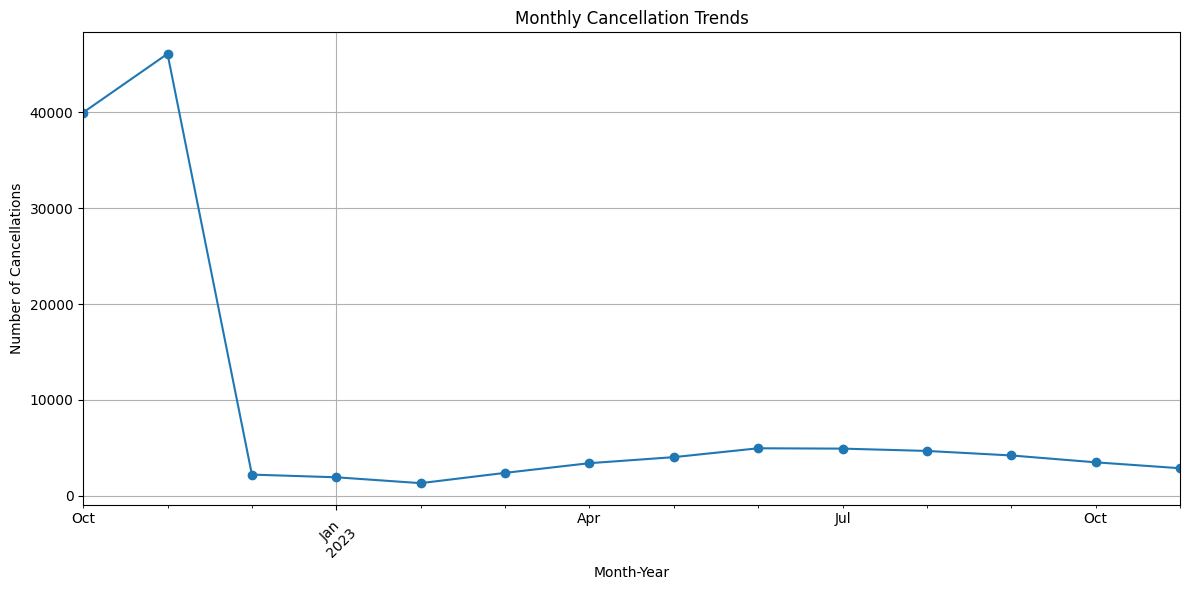

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cancelled_flights_df is already defined and loaded with your data
# Make sure 'dateoforigin' is in datetime format
cancelled_flights_df['dateoforigin'] = pd.to_datetime(cancelled_flights_df['dateoforigin'])

# Create a new column 'month_year' to group cancellations by month and year
cancelled_flights_df['month_year'] = cancelled_flights_df['dateoforigin'].dt.to_period('M')

# Count the number of cancellations for each 'month_year'
cancellations_over_time = cancelled_flights_df.groupby('month_year').size()

# Plotting the trend of cancellations over time
plt.figure(figsize=(12, 6))  # Adjust the figure size as necessary
cancellations_over_time.plot(kind='line', title='Monthly Cancellation Trends', marker='o')
plt.xlabel('Month-Year')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

